# Results

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from datetime import datetime

from utils.log import load_from_json


run_root = Path('/tmp/share/runs/spacenet8/nenad')

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
run_root = Path('/tmp/share/runs/spacenet8/nenad')


model_names = ['segformer_b0_lr1.00e-04_bs2_31-05-2023-15-10', 'segformer_b1_10_epochs_02-06-2023-05-07', 'resnet34_lr1.00e-04_bs4_11-05-2023-08-13']
sample_images = {}
result = []
for model_name in model_names:
    run_path = run_root/model_name
    
    
    params_foundation = load_from_json(run_path/'foundation/params.json')
    params_flood = load_from_json(run_path/'flood/params.json')
    
    df_foundation = pd.read_csv(run_path/'foundation/eval_results.csv')
    df_flood = pd.read_csv(run_path/'flood/eval_results.csv')
    
    try:
        building_iou = df_foundation[df_foundation['type'] == 'building']['iou'].values[0]
    except KeyError:
        building_iou = df_foundation[df_foundation['class'] == 'building']['iou'].values[0]
    
    non_flooded_building_iou = df_flood[df_flood['class'] == 'non-flooded building']['iou'].values[0]
    flooded_building_iou = df_flood[df_flood['class'] == 'flooded building']['iou'].values[0]
    d = {
        'model_name_foundation': params_foundation['model_name'], 
        'model_name_flood': params_flood['model_name'], 
        'n_params_foundation': params_foundation['parameter_count'],
        'n_params_flood': params_flood['parameter_count'],
        'building_iou': building_iou,
        'non_flooded_building_iou': non_flooded_building_iou,
        'flooded_building_iou': flooded_building_iou
        }

    result.append(d)
    
    sample_images[params_foundation['model_name']] = run_path/'foundation/pngs/10300100AF395C00_2_16_51_pred.png'
    
    
result = pd.DataFrame(result)
result['n_params'] = result['n_params_foundation'] + result['n_params_flood']
result['mean_iou'] = (result['building_iou'] + result['non_flooded_building_iou'] + result['flooded_building_iou'])/3
result    

,model_name_foundation,model_name_flood,n_params_foundation,n_params_flood,building_iou,non_flooded_building_iou,flooded_building_iou,n_params,mean_iou
0,segformer_b0,segformer_b0_siamese,3733477,3804709,0.585207,0.522893,0.298529,7538186,0.468876
1,segformer_b1,segformer_b1_siamese,13698889,13767813,0.606103,0.586908,0.449668,27466702,0.547560
2,Resnet34_upsample,Resnet34_siamese_upsample,24512773,24531237,0.598397,0.550238,0.354266,49044010,0.500967


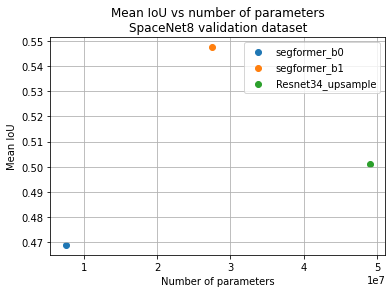

In [8]:
for index, row in result.iterrows():
    plt.scatter(row.n_params, row.mean_iou, label=row.model_name_foundation)

plt.title('Mean IoU vs number of parameters\nSpaceNet8 validation dataset')
plt.xlabel('Number of parameters')
plt.ylabel('Mean IoU')
plt.grid()
plt.legend()
plot_name = f'result_{datetime.now().strftime("%d-%m-%Y-%H-%M")}.png'
plt.savefig(f'results/{plot_name}')  # TODO saved figure is not pretty
plt.show()


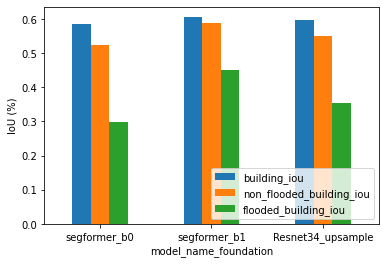

In [9]:
df_result = result
df_result.plot(x='model_name_foundation', y=['building_iou', 'non_flooded_building_iou', 'flooded_building_iou'], kind='bar')
plt.xticks(rotation=0)
plt.ylabel('IoU (%)')
plt.legend(loc='lower right')
plt.gcf()
plt.show()


segformer_b0


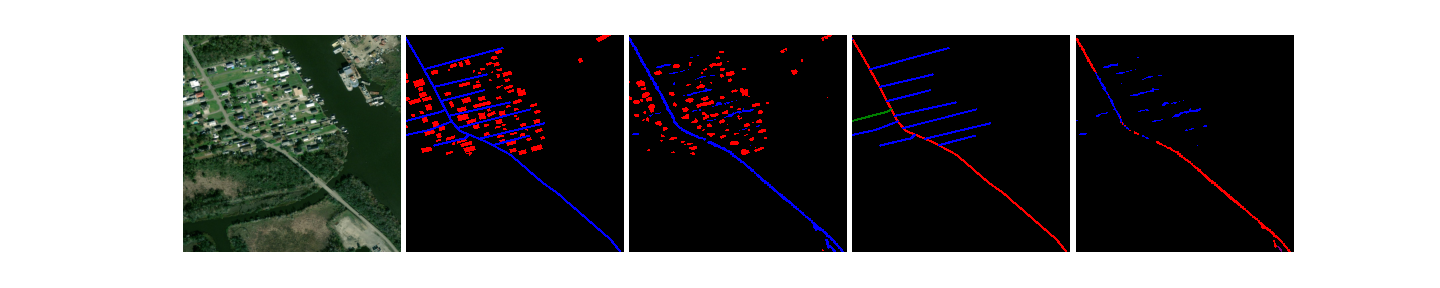

segformer_b1


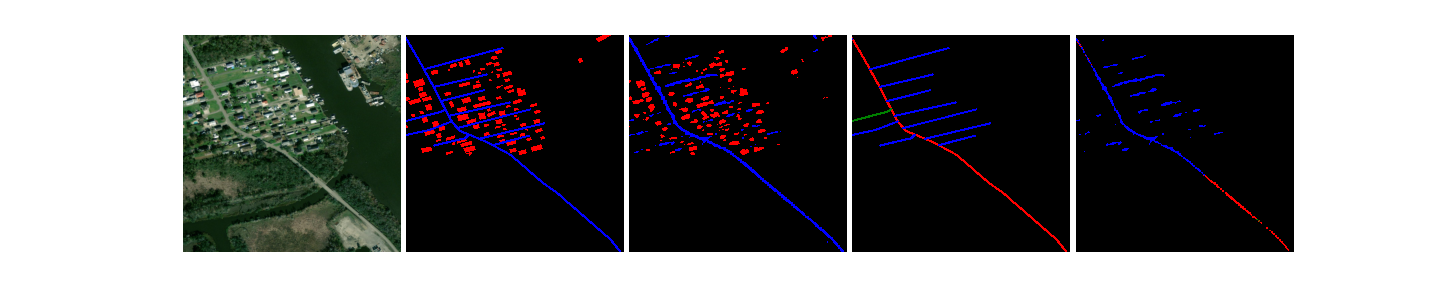

Resnet34_upsample


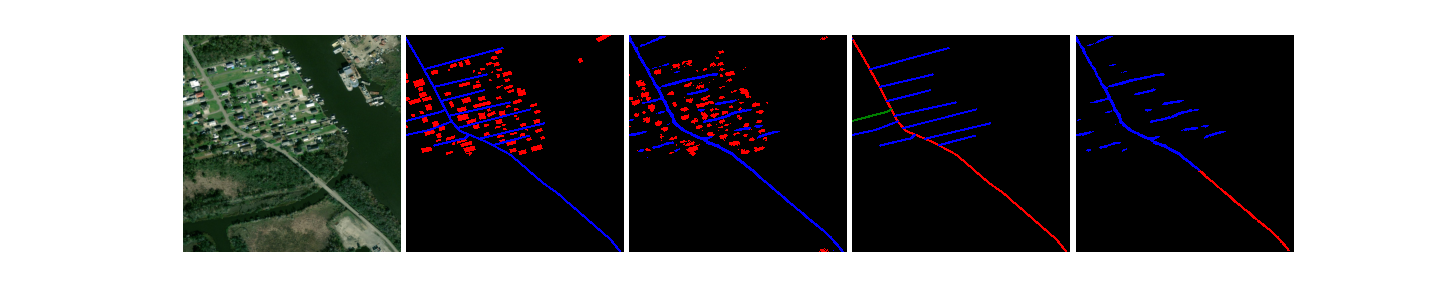

In [10]:
for name, sample_image in sample_images.items():
    image = Image.open(sample_image)
    print(name)
    image.show(title=name)
